## 1. Where are the old left-handed people?

<p>In this notebook, we will explore this phenomenon using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates of left-handedness over time, refuting the claim of early death for left-handers. This notebook uses <code>pandas</code> and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed.</p>
<p>A National Geographic survey in 1986 resulted in over a million responses that included age, sex, and hand preference for throwing and writing. Researchers Avery Gilbert and Charles Wysocki analyzed this data and noticed that rates of left-handedness were around 13% for people younger than 40 but decreased with age to about 5% by the age of 80. They concluded based on analysis of a subgroup of people who throw left-handed but write right-handed that this age-dependence was primarily due to changing social acceptability of left-handedness. This means that the rates aren't a factor of <em>age</em> specifically but rather of the <em>year you were born</em>, and if the same study was done today, we should expect a shifted version of the same distribution as a function of age. Ultimately, we'll see what effect this changing rate has on the apparent mean age of death of left-handed people, but let's start by plotting the rates of left-handedness as a function of age.</p>
<p>This notebook uses two datasets: <a href="https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf">death distribution data</a> for the United States from the year 1999 (source website <a href="https://www.cdc.gov/nchs/nvss/mortality_tables.htm">here</a>) and rates of left-handedness digitized from a figure in this <a href="https://www.ncbi.nlm.nih.gov/pubmed/1528408">1992 paper by Gilbert and Wysocki</a>. </p>

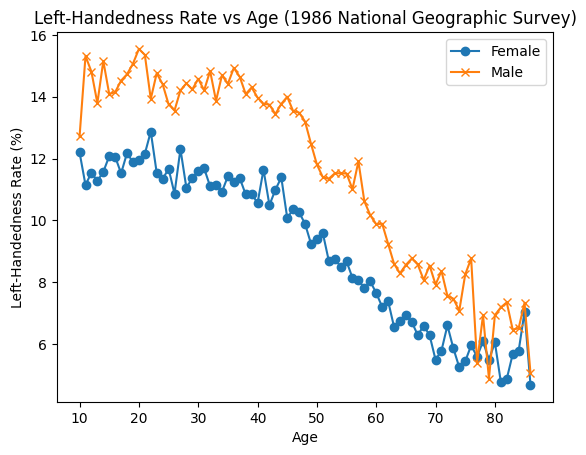

In [1]:
# 1 import libraries
import pandas as pd
import matplotlib.pyplot as plt

# 2. Load the data into a pandas DataFrame named lefthanded_data using the provided data_url_1
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

# 3. Use the .plot() method to create a plot of the ‘Male’ and ‘Female’ columns vs. ‘Age’
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects

# plot Female vs. Age with circles
ax.plot(lefthanded_data["Age"], lefthanded_data["Female"], label="Female", marker='o')

# plot Male vs. Age with crosses
ax.plot(lefthanded_data["Age"], lefthanded_data["Male"], label="Male", marker='x')

# add labels and legend
ax.legend()
ax.set_xlabel("Age")
ax.set_ylabel("Left-Handedness Rate (%)")

# add title
ax.set_title("Left-Handedness Rate vs Age (1986 National Geographic Survey)")

# 4. Show the plot
plt.show()

## 2. Rates of left-handedness over time
<p>Let's convert this data into a plot of the rates of left-handedness as a function of the year of birth, and average over male and female to get a single rate for both sexes. </p>
<p>Since the study was done in 1986, the data after this conversion will be the percentage of people alive in 1986 who are left-handed as a function of the year they were born. </p>

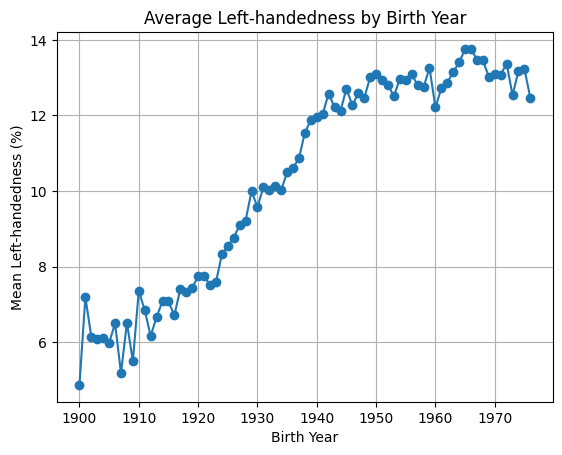

In [2]:
# 1. Create a column in lefthanded_data called Birth_year, which is equal to 1986 - Age (since the study was done in 1986).
lefthanded_data["Birth_year"] = 1986 - lefthanded_data["Age"]

# 2. Create a column in lefthanded_data called Mean_lh which is equal to the mean of the Male and Female columns.
lefthanded_data["Mean_lh"] = (lefthanded_data["Male"] + lefthanded_data["Female"]) / 2

# 3. Use the .plot() method to plot Mean_lh vs. Birth_year.
fig, ax = plt.subplots()

# plot 'Mean_lh' vs. 'Birth_year', The marker='o' helps visualize each data point.
ax.plot(lefthanded_data["Birth_year"], lefthanded_data["Mean_lh"], marker='o', linestyle='-')
ax.set_xlabel("Birth Year") # set the x label for the plot
ax.set_ylabel("Mean Left-handedness (%)") # set the y label for the plot
ax.set_title("Average Left-handedness by Birth Year")  # set title

# plt.grid(True) improves readability.
plt.grid(True)

# 4. Show the plot
plt.show()

## 3. Applying Bayes' rule
<p>The probability of dying at a certain age given that you're left-handed is <strong>not</strong> equal to the probability of being left-handed given that you died at a certain age. This inequality is why we need <strong>Bayes' theorem</strong>, a statement about conditional probability which allows us to update our beliefs after seeing evidence. </p>
<p>We want to calculate the probability of dying at age A given that you're left-handed. Let's write this in shorthand as P(A | LH). We also want the same quantity for right-handers: P(A | RH). </p>
<p>Here's Bayes' theorem for the two events we care about: left-handedness (LH) and dying at age A.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>P(LH | A) is the probability that you are left-handed <em>given that</em> you died at age A. P(A) is the overall probability of dying at age A, and P(LH) is the overall probability of being left-handed. We will now calculate each of these three quantities, beginning with P(LH | A).</p>
<p>To calculate P(LH | A) for ages that might fall outside the original data, we will need to extrapolate the data to earlier and later years. Since the rates flatten out in the early 1900s and late 1900s, we'll use a few points at each end and take the mean to extrapolate the rates on each end. The number of points used for this is arbitrary, but we'll pick 10 since the data looks flat-ish until about 1910. </p>

In [3]:
#  1. Import the numpy package aliased as np
import numpy as np

# Define the function to compute P(Left-handed | Age at Death)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """
    Calculates probability of being left-handed based on age at death and historical birth year trends.

    Parameters:
    - ages_of_death: numpy array of ages at which people died
    - study_year: year the data was collected (default = 1990)

    Returns:
    - A numpy array of probabilities of left-handedness given that subjects died in `study_year` at specified `ages_of_death`
    """

    # 2. Use the last ten Mean_lh data points for the early 1900s rate
    early_1900s_rate = lefthanded_data['Mean_lh'].tail(10).mean()  # Mean of oldest 10 birth years

    # 3. Use the first ten Mean_lh data points for the late 1900s rate
    late_1900s_rate = lefthanded_data['Mean_lh'].head(10).mean()  # Mean of youngest 10 birth years

    # Compute middle rates using study year minus ages of death
    birth_years = study_year - ages_of_death
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(birth_years), 'Mean_lh']

    # Define valid age range based on data collection year (1986)
    youngest_age = study_year - 1986 + 10  # Minimum age (10-year-olds in 1986)
    oldest_age = study_year - 1986 + 86   # Maximum age (86-year-olds in 1986)

    # Create an array to store the resulting probabilities
    P_return = np.zeros(ages_of_death.shape)  # Empty result array

    # 4&5. Fill in P_return for ages outside the dataset range using early and late 1900s rates (as a fraction /100)
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100       # Assign early 1900s rate to ages older than dataset
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100      # Assign late 1900s rate to ages younger than dataset

    # Assign actual rates for ages within the dataset
    valid_mask = np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))
    P_return[valid_mask] = middle_rates.values / 100    # Convert % to decimal

    return P_return

## 4. When do people normally die?
<p>To estimate the probability of living to an age A, we can use data that gives the number of people who died in a given year and how old they were to create a distribution of ages of death. If we normalize the numbers to the total number of people who died, we can think of this data as a probability distribution that gives the probability of dying at age A. The data we'll use for this is from the entire US for the year 1999 - the closest I could find for the time range we're interested in. </p>
<p>In this block, we'll load in the death distribution data and plot it. The first column is the age, and the other columns are the number of people who died at that age. </p>

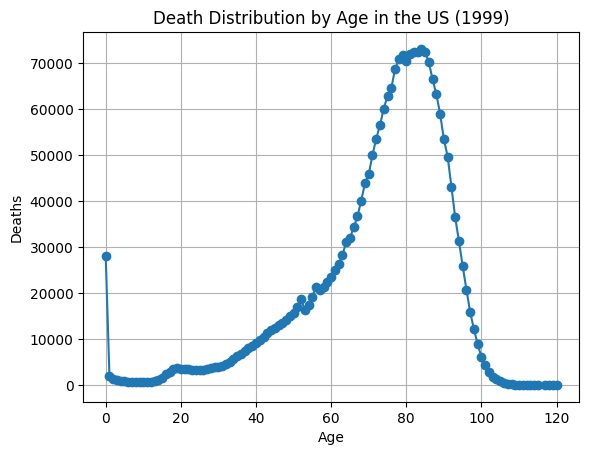

In [4]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# 1. Load death distribution data with appropriate parameters
death_distribution_data = pd.read_csv(data_url_2, sep='\t', skiprows=[1])
# sep='\t' specifies that the file is tab-separated (TSV)
# skiprows=[1] skips the second line (row 1), which contains metadata and not actual data

# 2. Drop NaN values from the 'Both Sexes' column
death_distribution_data = death_distribution_data.dropna(subset=['Both Sexes'])
# This ensures we only use rows where death counts for both sexes are valid numbers

# 3. Plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o') # plot 'Both Sexes' vs. 'Age'
# The marker='o' helps visualize each data point with circle markers

# Set axis labels
ax.set_xlabel('Age')         # X-axis: age of deceased
ax.set_ylabel('Deaths')      # Y-axis: number of people who died

# Optional: add title and grid for clarity
plt.title('Death Distribution by Age in the US (1999)')
plt.grid(True)

# Show the plot
plt.show()

## 5. The overall probability of left-handedness
<p>In the previous code block we loaded data to give us P(A), and now we need P(LH). P(LH) is the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability. In equation form, this is what we're calculating, where N(A) is the number of people who died at age A (given by the dataframe <code>death_distribution_data</code>):</p>
<p><img src="https://i.imgur.com/gBIWykY.png" alt="equation" width="220"></p>
<!--- $$P(LH) = \frac{\sum_{\text{A}} P(LH | A) N(A)}{\sum_{\text{A}} N(A)}$$ -->

In [5]:
def P_lh(death_distribution_data, study_year=1990):
    """
    Overall probability of being left-handed if you died in the given study year.
    Arguments:
        death_distribution_data: DataFrame containing death data by age (with 'Both Sexes' column)
        study_year: year the study is conducted (default = 1990)
    Returns:
        P(LH): Weighted probability of being left-handed across all age groups in the given year’s death data
    """

    # Extract ages from the death distribution data
    ages_of_death = death_distribution_data['Age'].values

    # Get the number of people who died at each age
    deaths = death_distribution_data['Both Sexes'].values

    # Compute probability of being left-handed at each age using your function from Task 3
    probabilities = P_lh_given_A(ages_of_death, study_year)

    # 1.  Multiply each age group's death count by P(LH | A) → weighted left-handed count
    p_list = deaths * probabilities

    # 2. Sum over all age groups to get total left-handed deaths
    p = p_list.sum()

    # 3. Normalize by total number of people who died (sum of "Both Sexes")
    total_deaths = deaths.sum()
    p_lh = p / total_deaths

    return p_lh

# Example usage
print(P_lh(death_distribution_data))

0.07766387615350638


## 6. Putting it all together: dying while left-handed (i)
<p>Now we have the means of calculating all three quantities we need: P(A), P(LH), and P(LH | A). We can combine all three using Bayes' rule to get P(A | LH), the probability of being age A at death (in the study year) given that you're left-handed. To make this answer meaningful, though, we also want to compare it to P(A | RH), the probability of being age A at death given that you're right-handed. </p>
<p>We're calculating the following quantity twice, once for left-handers and once for right-handers.</p>
<p>$$P(A | LH) = \frac{P(LH|A) P(A)}{P(LH)}$$</p>
<p>First, for left-handers.</p>
<!--Notice that I was careful not to call these "probability of dying at age A", since that's not actually what we're calculating: we use the exact same death distribution data for each. -->

In [6]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year=1990):
    """
    Calculates the probability of dying at a particular age (or ages), given that the person was left-handed.

    Inputs:
    - ages_of_death: array or Series of ages
    - death_distribution_data: DataFrame containing death counts by age (column 'Both Sexes')
    - study_year: Year of study (default 1990)

    Returns:
    - An array of probabilities: P(A | LH) for each age in ages_of_death
    """

    # 1. Calculate P(A): the probability of dying at age A
    # = Number of deaths at age A / Total deaths
    total_deaths = death_distribution_data['Both Sexes'].sum()
    P_A = death_distribution_data.loc[death_distribution_data['Age'].isin(ages_of_death),'Both Sexes'].values / total_deaths

    # 2. Calculate P(LH): overall probability of being left-handed (scalar)
    P_left = P_lh(death_distribution_data, study_year)

    # 3. Calculate P(LH | A): probability of being left-handed given age of death (array)
    P_lh_A = P_lh_given_A(ages_of_death, study_year)

    # Apply Bayes' Theorem: P(A | LH) = [P(LH | A) * P(A)] / P(LH)
    return (P_lh_A * P_A) / P_left

## 7. Putting it all together: dying while left-handed (ii)
<p>And now for right-handers.</p>

In [7]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year=1990):
    """
    Calculates the probability of dying at a particular age given that the person was right-handed.

    Parameters:
    - ages_of_death: array or list of ages to compute probabilities for
    - death_distribution_data: DataFrame with 'Age' and 'Both Sexes' columns
    - study_year: the year of the study, used for historical left-handedness rates

    Returns:
    - A NumPy array of probabilities: P(A | RH) for each age in ages_of_death
    """

    # 1. Calculate P(A) = N(A) / Total deaths
    total_deaths = death_distribution_data['Both Sexes'].sum()
    P_A = death_distribution_data.loc[death_distribution_data['Age'].isin(ages_of_death),'Both Sexes'].values / total_deaths

    # 2. Calculate overall left-handed probability P(LH)
    P_left = P_lh(death_distribution_data, study_year)
    P_right = 1 - P_left     # P(RH) = 1 - P(LH), Compute overall right-handed probability

    # 3. Compute P(RH | A) = 1 - P(LH | A)
    P_lh_A = P_lh_given_A(ages_of_death, study_year)
    P_rh_A = 1 - P_lh_A

    # Apply Bayes' theorem: P(A | RH) = [P(RH | A) * P(A)] / P(RH)
    P_A_given_rh = (P_rh_A * P_A) / P_right
    return P_A_given_rh

## 8. Plotting the distributions of conditional probabilities
<p>Now that we have functions to calculate the probability of being age A at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120. </p>
<p>Notice that the left-handed distribution has a bump below age 70: of the pool of deceased people, left-handed people are more likely to be younger. </p>

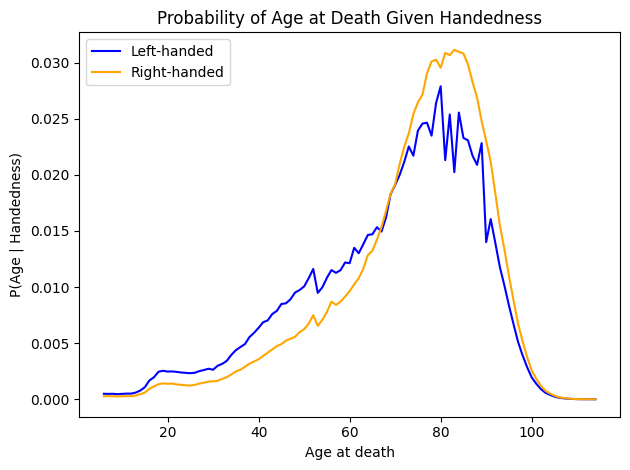

In [8]:
# Define the age range you want to evaluate
ages = np.arange(6, 115, 1) # Ages from 6 to 114

# 1. Calculate P_A_given_lh and P_A_given_rh using the functions defined in Task 6.
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# 2. Use the .plot() method to plot the two probabilities vs. age
fig, ax = plt.subplots()    # Set up a figure and axis for plotting

# Plot for left-handed individuals
ax.plot(ages, left_handed_probability, label="Left-handed", color='blue')
# Plot for right-handed individuals
ax.plot(ages, right_handed_probability, label="Right-handed", color='orange')

# Add legend, labels, and title for clarity
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel("P(Age | Handedness)")
ax.set_title("Probability of Age at Death Given Handedness")

# Show the plot
plt.tight_layout()
plt.show()

## 9. Moment of truth: age of left and right-handers at death
<p>Finally, let's compare our results with the original study that found that left-handed people were nine years younger at death on average. We can do this by calculating the mean of these probability distributions in the same way we calculated P(LH) earlier, weighting the probability distribution by age and summing over the result.</p>
<p>$$\text{Average age of left-handed people at death} = \sum_A A P(A | LH)$$</p>
<p>$$\text{Average age of right-handed people at death} = \sum_A A P(A | RH)$$</p>

In [9]:
# Make sure 'ages' and the probability arrays are aligned
ages = np.arange(6, 115, 1)  # list of ages from 6 to 114

# Use np.array for element-wise multiplication between age and probability arrays
# 1: Calculate the average age at death for left-handers
average_lh_age = np.nansum(np.array(ages) * np.array(left_handed_probability))
# 2: Calculate the average age at death for right-handers
average_rh_age = np.nansum(np.array(ages) * np.array(right_handed_probability))

# 3: Print the results, rounded to 2 decimal places
print("Average age at death for left-handed individuals:", round(average_lh_age, 2), "years")
print("Average age at death for right-handed individuals:", round(average_rh_age, 2), "years")

# 4: Calculate and print the difference in average ages
age_difference = round(average_rh_age - average_lh_age, 2)
print("The difference in average ages is", age_difference, "years.")

Average age at death for left-handed individuals: 67.25 years
Average age at death for right-handed individuals: 72.79 years
The difference in average ages is 5.55 years.


## 10. Final comments
<p>We got a pretty big age gap between left-handed and right-handed people purely as a result of the changing rates of left-handedness in the population, which is good news for left-handers: you probably won't die young because of your sinisterness. The reported rates of left-handedness have increased from just 3% in the early 1900s to about 11% today, which means that older people are much more likely to be reported as right-handed than left-handed, and so looking at a sample of recently deceased people will have more old right-handers.</p>
<p>Our number is still less than the 9-year gap measured in the study. It's possible that some of the approximations we made are the cause: </p>
<ol>
<li>We used death distribution data from almost ten years after the study (1999 instead of 1991), and we used death data from the entire United States instead of California alone (which was the original study). </li>
<li>We extrapolated the left-handedness survey results to older and younger age groups, but it's possible our extrapolation wasn't close enough to the true rates for those ages. </li>
</ol>
<p>One thing we could do next is figure out how much variability we would expect to encounter in the age difference purely because of random sampling: if you take a smaller sample of recently deceased people and assign handedness with the probabilities of the survey, what does that distribution look like? How often would we encounter an age gap of nine years using the same data and assumptions? We won't do that here, but it's possible with this data and the tools of random sampling. </p>
<!-- I did do this if we want to add more tasks - it would probably take three more blocks.-->
<p>To finish off, let's calculate the age gap we'd expect if we did the study in 2018 instead of in 1990. The gap turns out to be much smaller since rates of left-handedness haven't increased for people born after about 1960. Both the National Geographic study and the 1990 study happened at a unique time - the rates of left-handedness had been changing across the lifetimes of most people alive, and the difference in handedness between old and young was at its most striking. </p>

The difference in average ages is 2.34 years.


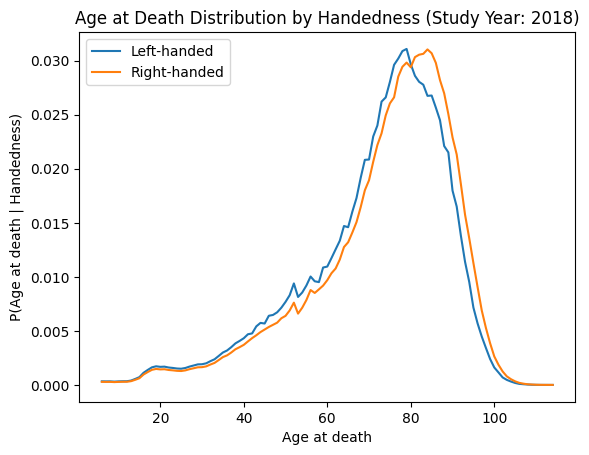

In [10]:
# Define the list of ages from 6 to 114
ages = np.arange(6, 115, 1)

# 1. Calculate P(A | LH) — probability of being a particular age at death, given person is left-handed, using data from 2018.
left_handed_probability_2018 = P_A_given_lh(
    ages_of_death=ages,                   # list of ages
    death_distribution_data=death_distribution_data,  # the same dataset
    study_year=2018                       # new study year
)

# 2. Similarly, calculate P(A | RH) for right-handed people in 2018.
right_handed_probability_2018 = P_A_given_rh(
    ages_of_death=ages,
    death_distribution_data=death_distribution_data,
    study_year=2018
)

# left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year=2018)
# right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year=2018)

# Calculate average age at death for left-handed and right-handed individuals in 2018
average_lh_age_2018 = np.nansum(ages * np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages * np.array(right_handed_probability_2018))

# Print the difference in average ages
print("The difference in average ages is " +
      str(round(average_rh_age_2018 - average_lh_age_2018, 2)) + " years.")

# Now plot the results to visually compare
fig, ax = plt.subplots()  # create a new figure and axis

# Plot the left-handed probability vs. age
ax.plot(ages, left_handed_probability_2018, label="Left-handed")

# Plot the right-handed probability vs. age
ax.plot(ages, right_handed_probability_2018, label="Right-handed")

# Add axis labels
ax.set_xlabel("Age at death")
ax.set_ylabel("P(Age at death | Handedness)")
ax.set_title("Age at Death Distribution by Handedness (Study Year: 2018)")

# Add legend to distinguish lines
ax.legend()

# Show the plot
plt.show()